# Caso Práctico: KMEANS
Realizaremos un ejercicio de prueba para comprender como funciona este algoritmo

## Conjunto de datos: Detección de incendios forestales en Colombia

## Descripción¶
El dataset proporciona información detallada sobre la detección de incendios forestales en Colombia, incluyendo información geoespacial, temperaturas, potencia radiativa y otros atributos relacionados. Estos datos son valiosos para el análisis y estudio de los incendios forestales en la región, permitiendo comprender patrones, distribuciones y características de estos eventos.

##  Descarga de los ficheros de datos
https://firms.modaps.eosdis.nasa.gov/country/



In [95]:
# Importamos todas las librerias que vamos a utilizar en este ejercicio.
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [96]:
dataframe = pd.read_csv("dataset/viirs-snpp_2021_Colombia.csv")
dataframe.head(10)

latitude  longitude  bright_ti4  scan  track    acq_date  acq_time  \
0  11.147054 -72.533997      313.72  0.45   0.39  2021-01-01       630   
1  11.141299 -72.543526      309.44  0.45   0.39  2021-01-01       630   
2  11.135450 -72.574265      318.17  0.45   0.39  2021-01-01       630   
3  11.084483 -72.678391      310.26  0.45   0.39  2021-01-01       630   
4  10.983885 -72.724060      305.98  0.45   0.39  2021-01-01       630   
5  10.979674 -72.720673      309.87  0.45   0.39  2021-01-01       630   
6  11.081628 -72.683197      306.62  0.45   0.39  2021-01-01       630   
7   9.763828 -73.474281      312.15  0.43   0.38  2021-01-01       630   
8   9.760345 -73.474854      315.00  0.43   0.38  2021-01-01       630   
9  11.132580 -72.579010      317.36  0.45   0.39  2021-01-01       630   

  satellite instrument confidence  version  bright_ti5   frp daynight  type  
0         N      VIIRS          n        1      291.93  1.57        N     0  
1         N      VIIRS          n        1      292.81  1.29        N     2  
2         N      VIIRS          n        1      293.13  3.23        N     2  
3         N      VIIRS          n        1      293.74  1.64        N     2  
4         N      VIIRS          n        1      292.84  1.40        N     0  
5         N      VIIRS          n        1      292.47  1.26        N     0  
6         N      VIIRS          n        1      293.40  1.47        N     2  
7         N      VIIRS          n        1      295.25  1.52        N     2  
8         N      VIIRS          n        1      295.55  1.52        N     2  
9         N      VIIRS          n        1      293.26  2.95        N     2

In [97]:
# Proporcionamos las estadisticas descriptivas de las columnas numericas.
dataframe.describe()

latitude     longitude    bright_ti4          scan         track  \
count  87615.000000  87615.000000  87615.000000  87615.000000  87615.000000   
mean       5.714836    -72.546235    335.967394      0.456896      0.468497   
std        2.992589      2.071876     14.580529      0.081203      0.107817   
min       -4.164764    -78.958702    208.000000      0.320000      0.360000   
25%        3.549520    -74.157627    331.620000      0.400000      0.380000   
50%        5.135781    -72.691391    336.830000      0.440000      0.430000   
75%        8.268107    -71.024666    343.720000      0.500000      0.540000   
max       12.254436    -67.032013    367.000000      0.800000      0.780000   

           acq_time  version    bright_ti5           frp          type  
count  87615.000000  87615.0  87615.000000  87615.000000  87615.000000  
mean    1625.972699      1.0    294.667858      9.933122      0.172927  
std      423.203517      0.0      7.809255     18.685286      0.617400  
min      506.000000      1.0    247.020000      0.120000      0.000000  
25%     1736.000000      1.0    290.350000      3.260000      0.000000  
50%     1806.000000      1.0    295.090000      5.540000      0.000000  
75%     1830.000000      1.0    299.480000      9.660000      0.000000  
max     1924.000000      1.0    374.690000    714.710000      3.000000

In [98]:
# Vemos cuantos usuarios hay de cada categoria.
print(dataframe.groupby('type').size())

type
0    80992
2     4718
3     1905
dtype: int64


Categoría 0: está relacionada con detecciones de eventos que no están relacionados con incendios.
Categoría 2: está relacionada con detecciones de eventos de incendios.
Categoría 3: Representa otro tipo de detección diferente de las dos categorías anteriores.

<h2 style="color: #32209B">Visualizamos los datos</h2>

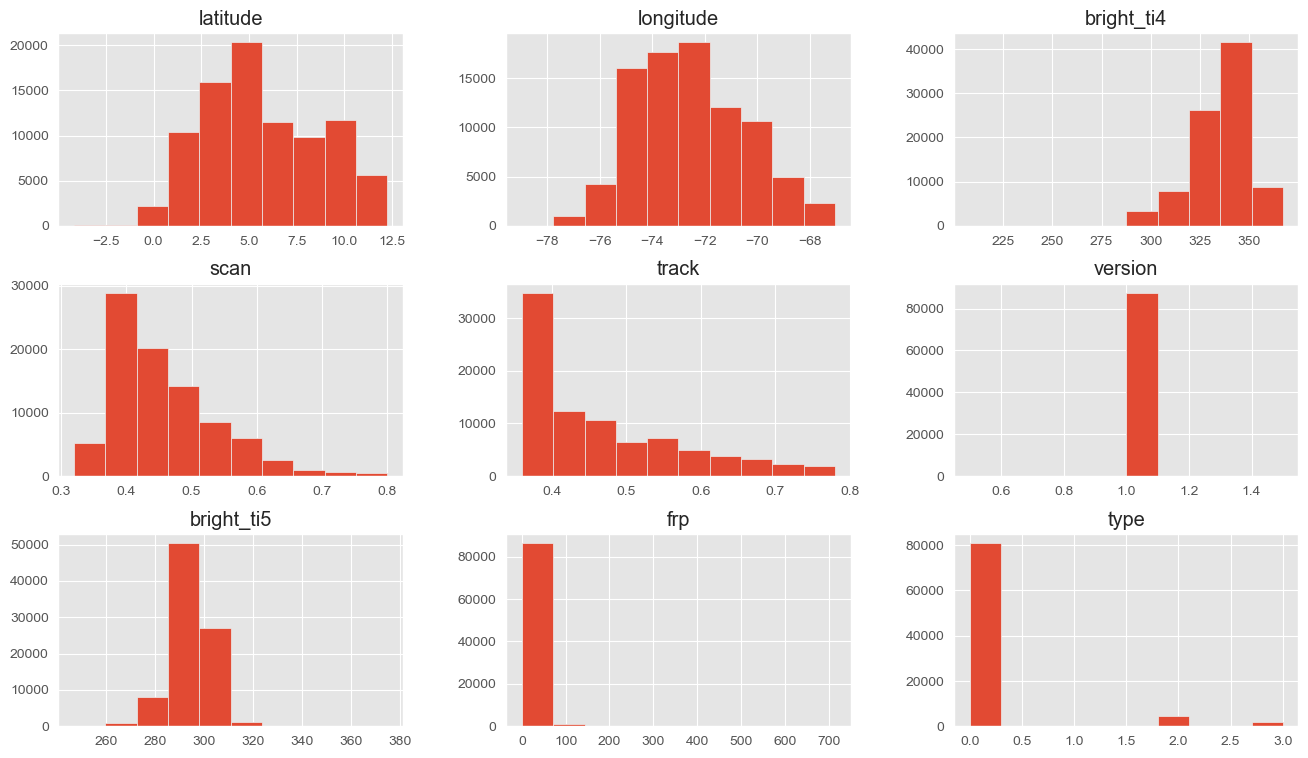

In [99]:
# Eliminamos las columnas que no queremos mostrar en el histo grama.
características = dataframe.drop(['acq_date', 'acq_time', 'daynight', 'satellite', 'confidence', 'instrument'], axis=1)

# Graficar histogramas para cada columna del DataFrame escalado
características.hist()
plt.show()

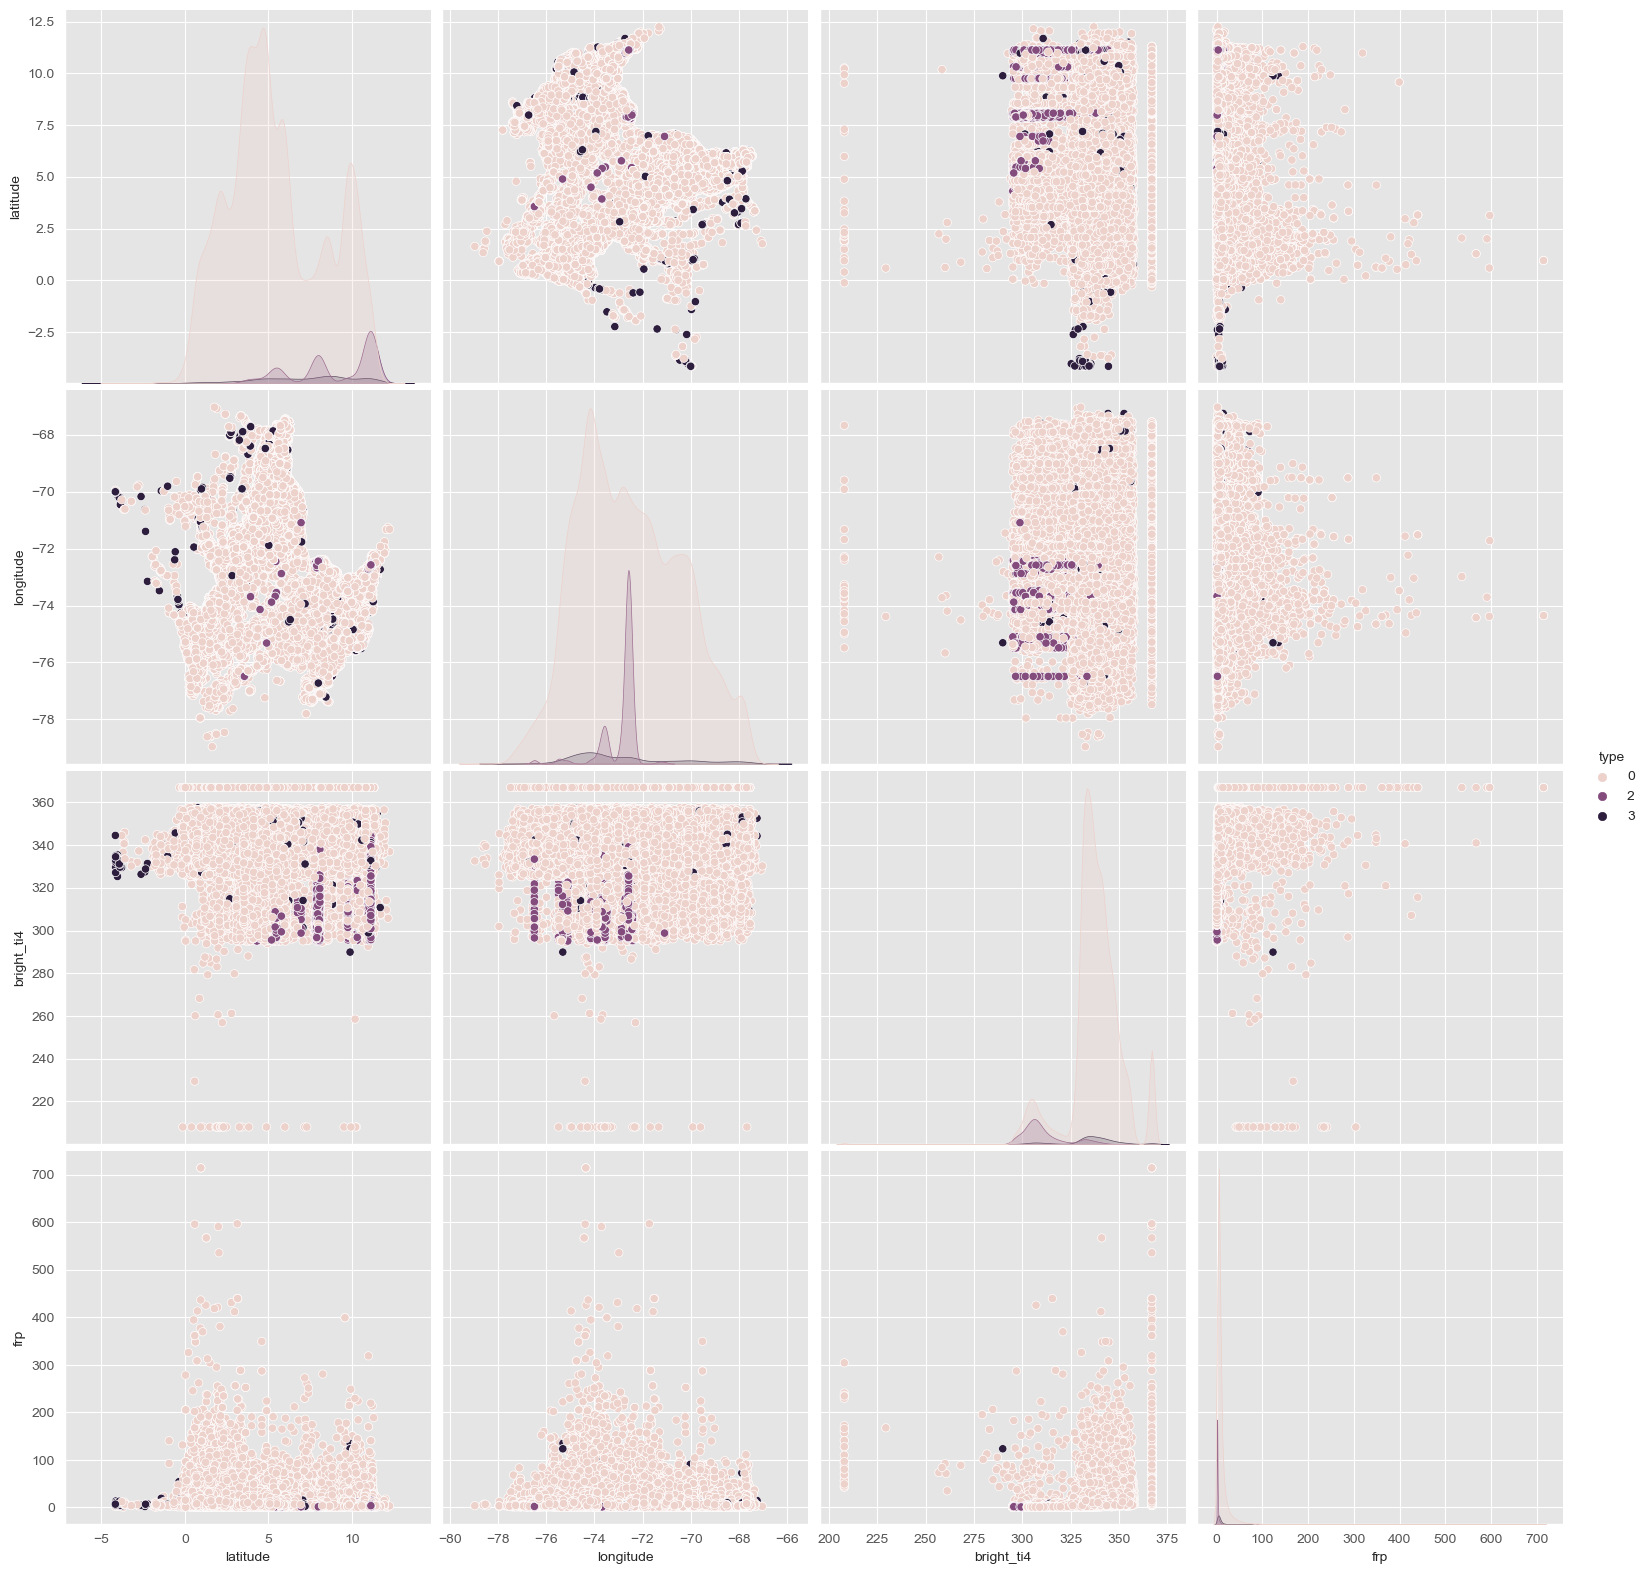

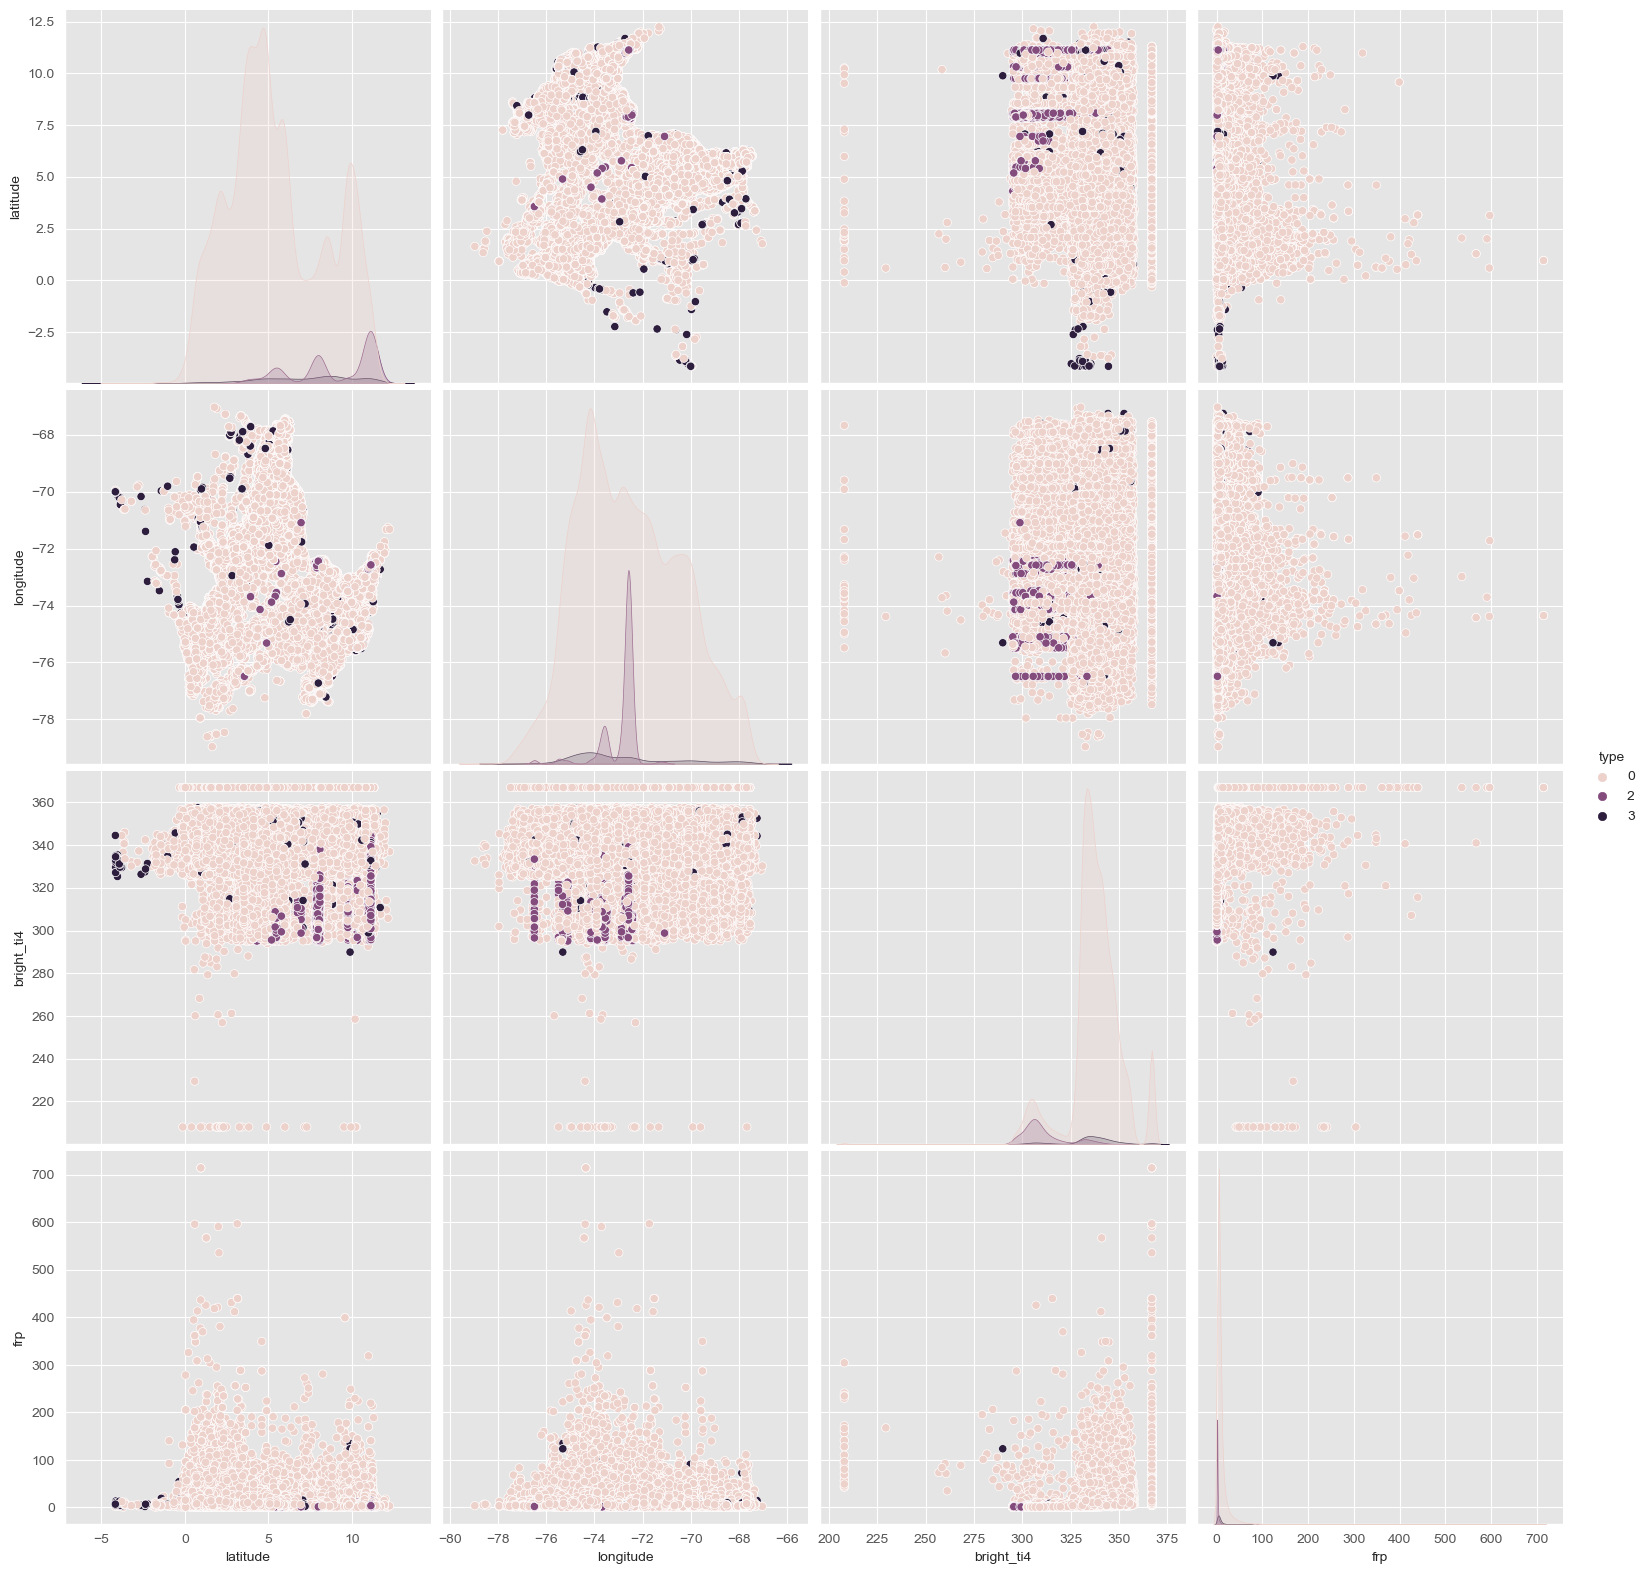

In [100]:
sb.pairplot(características.dropna(), hue='type', height=4, vars=['latitude', 'longitude', 'bright_ti4', 'frp'], kind='scatter')
plt.show()

<h2 style="color: #32209B">Creamos el modelo</h2>

In [101]:
#Para el ejercicio, sólo seleccionamos 4 dimensiones, para poder graficarlo
X = np.array(características[['latitude', 'longitude', 'bright_ti4', 'frp']])
y = np.array(características['type'])
X.shape

(87615, 4)

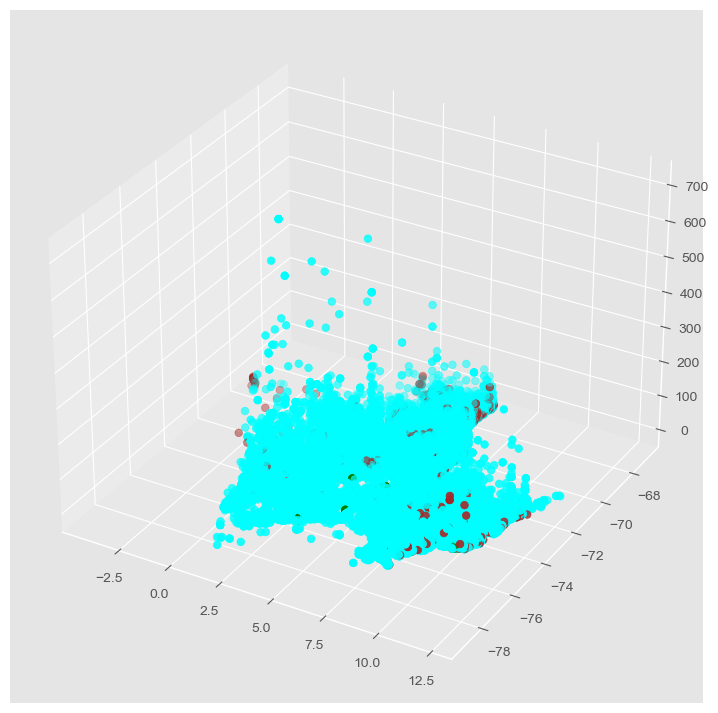

In [106]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colores=['cyan','red','green','brown','blue','yellow','orange','black','pink','brown','purple']
#NOTA: asignamos la posición cero del array repetida pues las categorias comienzan en id 1.
asignar=[]
for row in y:
    asignar.append(colores[row])

ax.scatter(X[:, 0], X[:, 1], X[:, 3], c=asignar, s=30)

# Mostrar el gráfico
plt.show()

<h2 style="color: #32209B">Buscamos el valor K</h2>

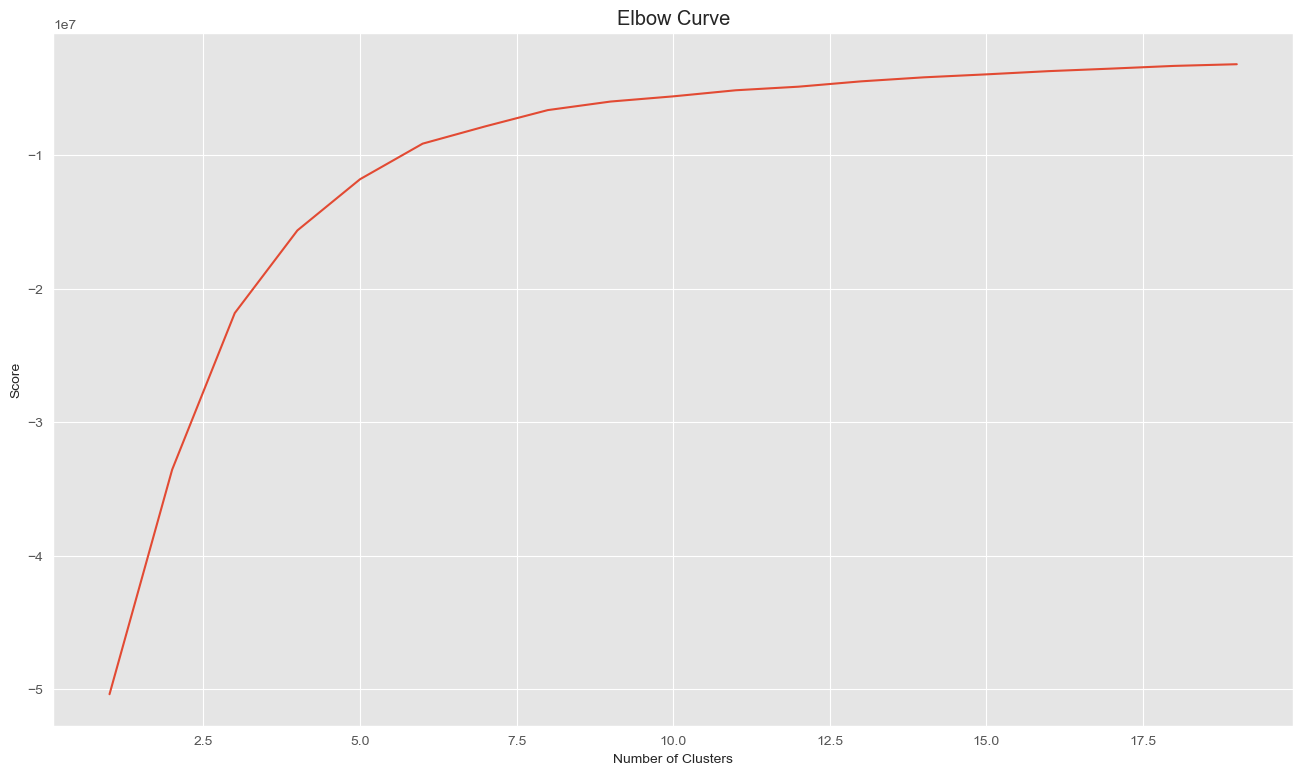

In [103]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i, n_init=10) for i in Nc]
kmeans
# Aquí se ajusta cada modelo de K-Means a los datos X y se calcula la inercia (suma de distancias al cuadrado de los puntos a sus centroides) para cada modelo. Los valores de inercia se almacenan en la lista score.
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score

plt.plot(Nc, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [104]:
# Para el ejercicio, elijo 5 como un buen valor de K. Pero podría ser otro.
kmeans = KMeans(n_clusters=6, n_init=10).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[  5.54550356 -72.59345108 335.63495154   5.67781062]
 [  2.53188458 -73.28984164 350.75066667 412.916     ]
 [  7.29690214 -72.32375071 306.65162954   1.71121137]
 [  5.51568873 -72.42662478 351.33820969  12.8799231 ]
 [  3.57094765 -73.44020345 344.26485294 140.44058824]
 [  4.78749832 -73.00936799 345.62682234  47.46157614]]


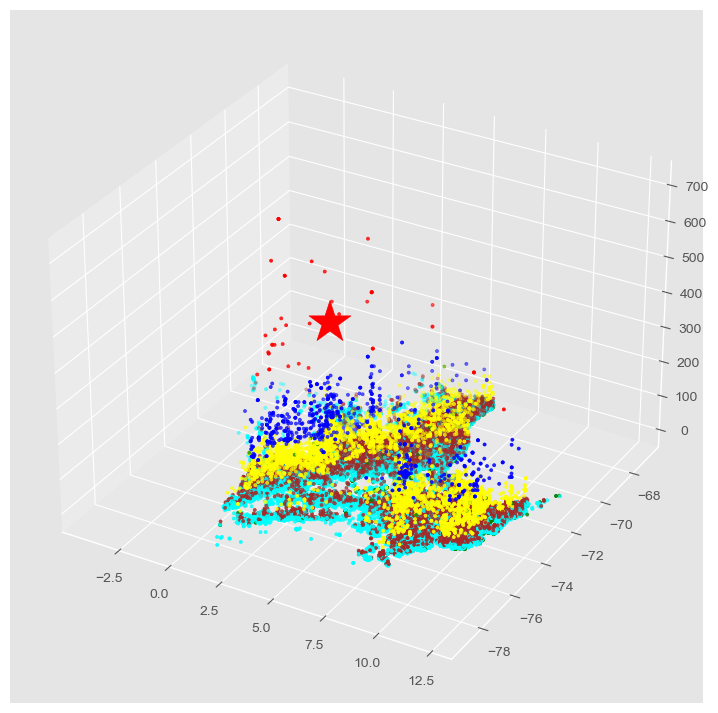

In [142]:
# Obtenemos las etiquetas de cada punto de nuestros datos
labels = kmeans.predict(X)

# Obtenemos los centroids
C = kmeans.cluster_centers_
colores=['cyan','red','green','brown','blue','yellow']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

asignar=[]
for row in labels:
    asignar.append(colores[row])

ax.scatter(X[:, 0], X[:, 1], X[:, 3], c=asignar,s=5)
ax.scatter(C[:, 0], C[:, 1], C[:, 3], marker='*', c=colores, s=1000)
plt.show()

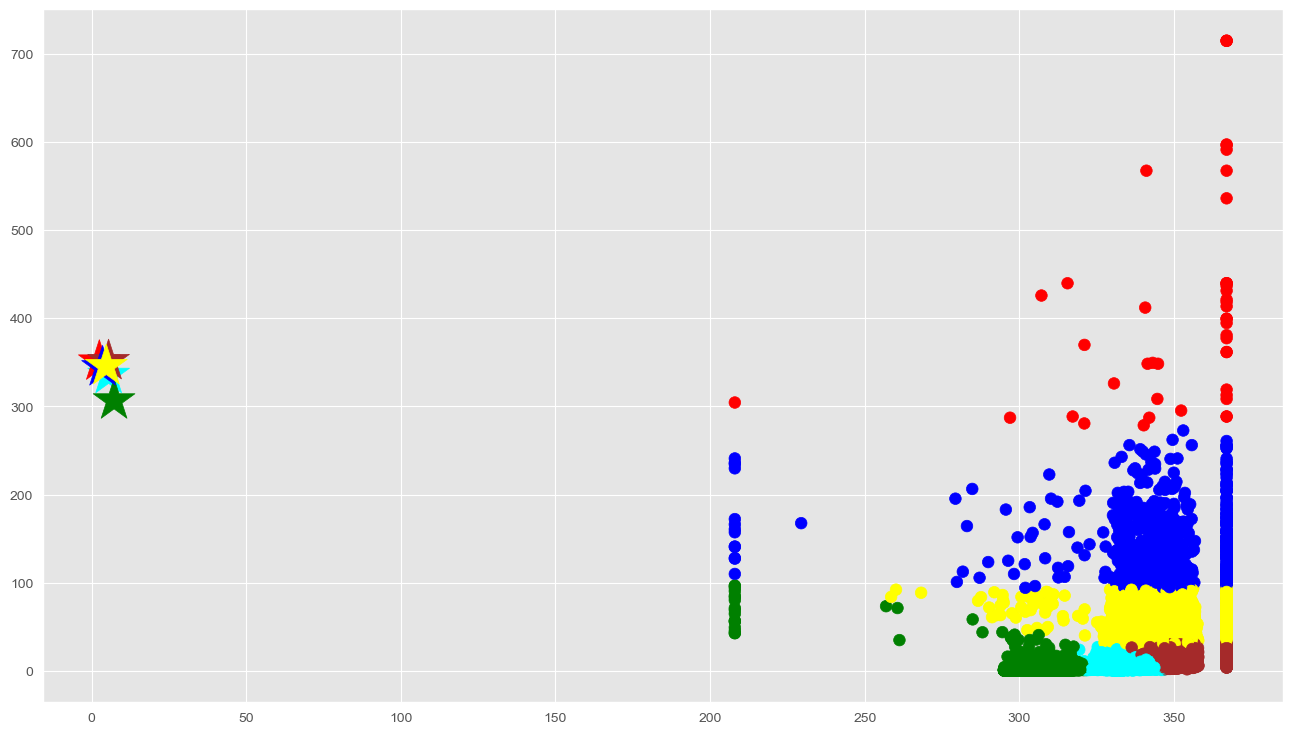

In [151]:
# Hacemos una proyección a 2D con los diversos ejes
f1 = dataframe['bright_ti4'].values
f2 = dataframe['frp'].values

plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 2], marker='*', c=colores, s=1000)
plt.show()

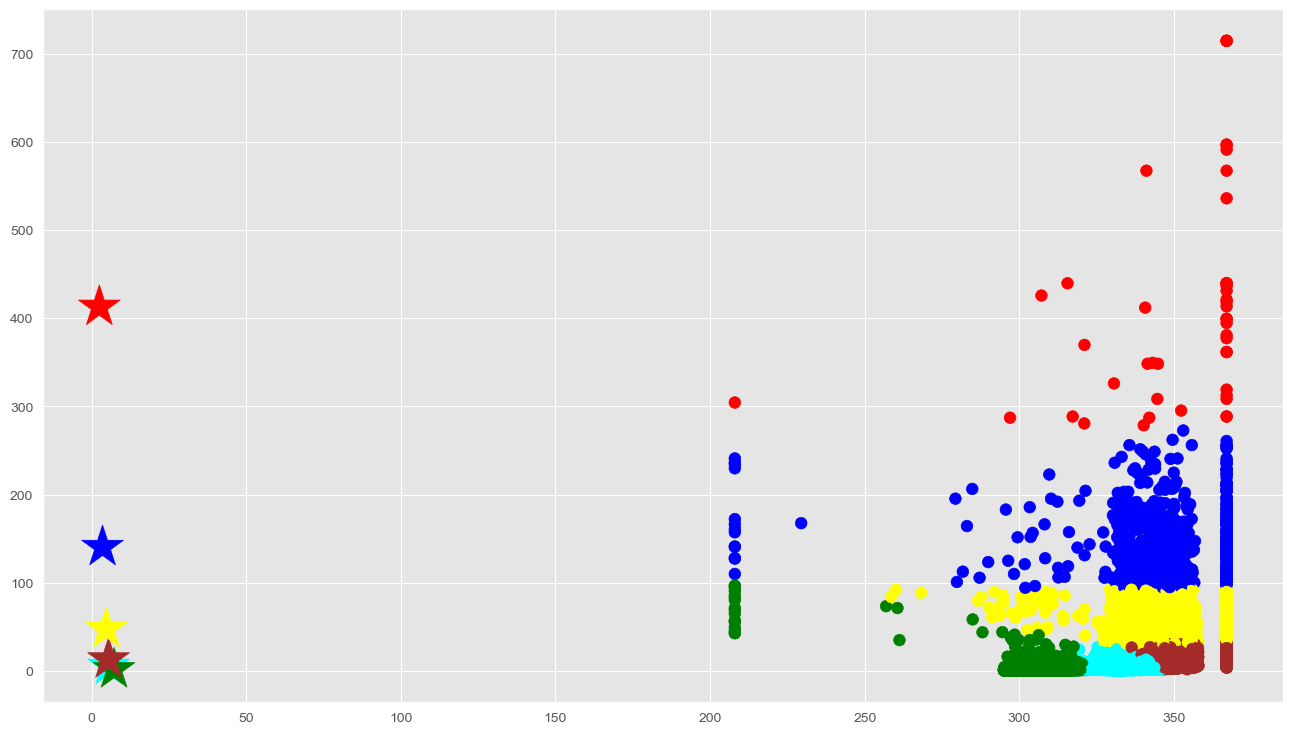

In [150]:
# Hacemos una proyección a 2D con los diversos ejes
f1 = dataframe['bright_ti4'].values
f2 = dataframe['frp'].values


plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 3], marker='*', c=colores, s=1000)
plt.show()

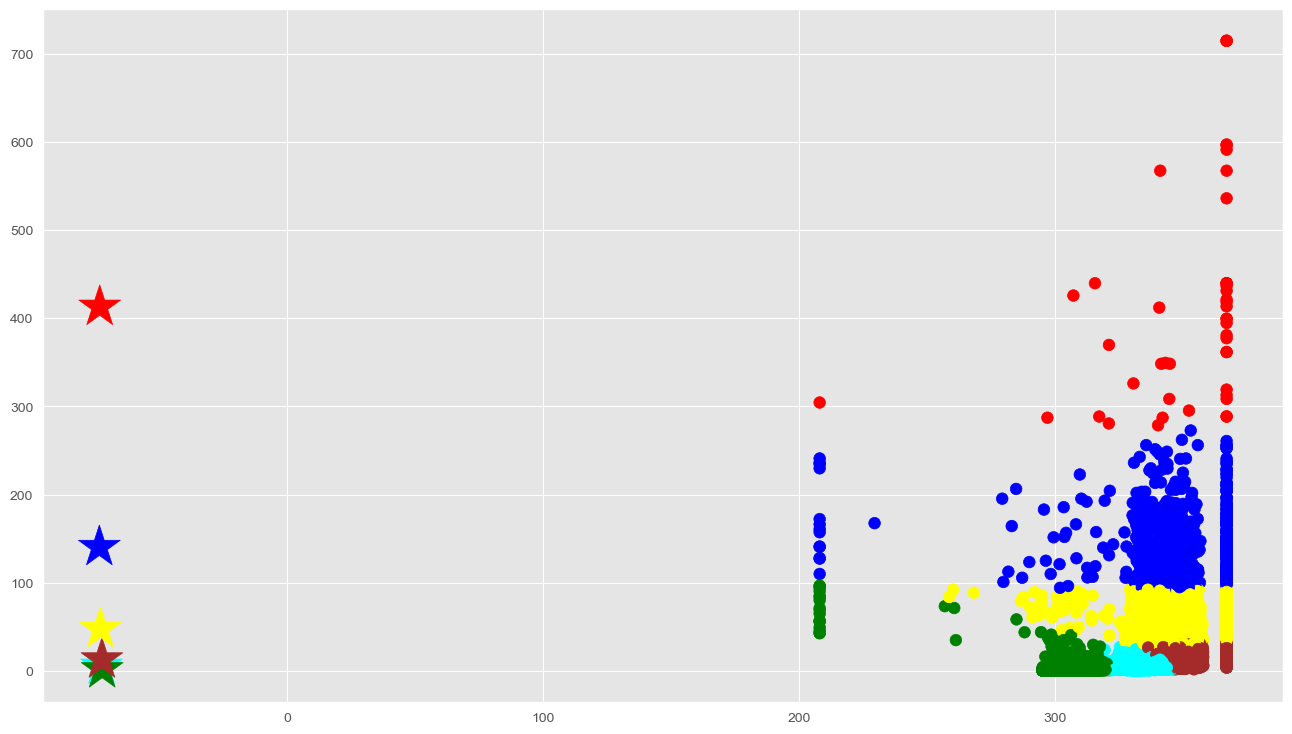

In [149]:
f1 = dataframe['bright_ti4'].values
f2 = dataframe['frp'].values

'''
# este codigo comentado agrega las categorias sobre cada punto
for label, x, y in zip(dataframe['categoria'].values, f1, f2):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
'''
plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 1], C[:, 3], marker='*', c=colores, s=1000)
plt.show()

In [174]:
# contamos cuantos usuarios hay en cada grupo
copy =  pd.DataFrame()
copy['categoria']=dataframe['type'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

ValueError: Length of values (6) does not match length of index (87615)

In [163]:
# Veamos cuantos usuarios en cada categoria hay en el grupo 0
group_referrer_index = copy['label'] == 0
group_referrals = copy[group_referrer_index]
diversidadGrupo =  pd.DataFrame()
diversidadGrupo['categoria']=[0,1,2,3,4,5,6]
diversidadGrupo['cantidad']=group_referrals.groupby('categoria').size()
diversidadGrupo

categoria  cantidad
0          0   49791.0
1          1       NaN
2          2     695.0
3          3    1225.0
4          4       NaN
5          5       NaN
6          6       NaN

In [165]:
#imprimimos en pantalla los usuarios con categoria 2 del grupo
for index, row in group_referrals.iterrows():
    if row["categoria"] == 2:
        print ( row["categoria"],row["label"])

2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0


In [166]:
#vemos el representante del grupo, el usuario cercano a su centroid
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
closest

array([10122, 39232, 61327, 35722, 34675, 21755], dtype=int64)

In [177]:
users=dataframe['type'].values
for row in closest:
    print(users[row])

0
0
2
0
0
0


In [178]:
#miramos los tipos del grupo 0
for index, row in copy.iterrows():
    if row["label"] == 0:
        print (row["categoria"],row["label"])

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
2.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
2.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
2.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


<h2 style="color: #32209B">Clasificación de nuevos registros</h2>

In [184]:
X_new = np.array([[45.92, 57.74, 15.66, 33.55]]) #davidguetta personality traits
new_labels = kmeans.predict(X_new)
print(new_labels)



[2]
